In [1]:
# ==============================================================================
# IMPORTS AND SETUP
# ==============================================================================

import numpy as np
import torch
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pytorch_lightning as pl

# Local imports
from fetch_yuriy_data import get_yuriy_data
from conv_lun_model import ConvLUNModel
from neural_net_trainer import NeuralNetTrainer
from training_utils import MetricsLogger, create_data_loaders

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cpu


In [2]:
# ==============================================================================
# DATA LOADING AND PREPROCESSING
# ==============================================================================

# Load and prepare data
print("Loading and preprocessing data...")
X, Y, meta_data = get_yuriy_data(samples_around=300)

# Convert labels to 0-based indexing and encode
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Convert to torch tensors and transpose to (trials, channels, timepoints)
X_tensor = torch.from_numpy(X).float().permute(0, 2, 1)  # (trials, time, channels) -> (trials, channels, time)
Y_tensor = torch.from_numpy(Y_encoded).long()

# Split data into train/test
X_train, X_test, Y_train, Y_test = train_test_split(
    X_tensor, Y_tensor, test_size=0.2, random_state=42, stratify=Y_tensor
)

# Add channel dimension for ConvLUN model: (batch, 1, channels, time)
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

# Display data info
print(f"Data shape: {X.shape} -> Processed: {X_train.shape}")
print(f"Classes: {np.unique(Y)} -> Encoded: {np.unique(Y_encoded)}")
print(f"Channels: {len(meta_data['channel_names'])}, Sampling freq: {meta_data['sampFreq']} Hz")
print(f"Train/Test split: {X_train.shape[0]}/{X_test.shape[0]} samples")


Loading and preprocessing data...
Data shape: (1388, 600, 19) -> Processed: torch.Size([1110, 1, 19, 600])
Classes: [1 2] -> Encoded: [0 1]
Channels: 19, Sampling freq: 200 Hz
Train/Test split: 1110/278 samples


In [3]:
# ==============================================================================
# MODEL CONFIGURATION
# ==============================================================================

# Model parameters
n_outputs = len(np.unique(Y_encoded))
n_chans = X_tensor.shape[1]  # Number of channels  
n_times = X_tensor.shape[2]  # Number of time samples
sfreq = meta_data['sampFreq']

# Create ConvLUN model
model = ConvLUNModel(
    num_channels=n_chans,
    num_time_steps=n_times,
    channels=[25, 25, 50, 100, 200],
    temporal_kernel_1=100,
    temporal_kernel_2=10,
    dropout_rate=0.25,
)

print(f"Model configured with {n_outputs} classes, {n_chans} channels, {n_times} timepoints")


Model configured with 2 classes, 19 channels, 600 timepoints


In [4]:
# ==============================================================================
# TRAINING EXECUTION
# ==============================================================================

# Setup trainer
nntrainer = NeuralNetTrainer(
    model=model,
    loss_fn=torch.nn.CrossEntropyLoss(),
    learning_rate=0.001,
    metrics={'accuracy': lambda y_hat, y: torch.mean((torch.argmax(y_hat, dim=1) == y).float())},
    scheduler=lr_scheduler.ReduceLROnPlateau,
    scheduler_kwargs={
        'factor': 0.1,
        'patience': 10,
        'min_lr': 1e-6,
    },
)

# Create data loaders
train_loader, val_loader = create_data_loaders(
    X_train, 
    Y_train, 
    batch_size=32, 
    loader_kwargs={
        'num_workers': 30, 
        'persistent_workers': True
    }
)

# Setup metrics logging and trainer
metrics_logger = MetricsLogger(to_log=['accuracy', 'loss'])
trainer = pl.Trainer(
    max_epochs=100, 
    callbacks=[
        metrics_logger, 
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=30)
    ]
)

# Train model
print("Starting training...")
trainer.fit(nntrainer, train_loader, val_loader)
print("Training completed!")

/Users/alejandro/VSCodeProjects/Models/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/alejandro/VSCodeProjects/Models/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_c

Starting training...


/Users/alejandro/VSCodeProjects/Models/.venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 82: 100%|██████████| 28/28 [00:11<00:00,  2.46it/s, v_num=0, train_loss_step=0.00277, val_loss=0.121, train_loss_epoch=0.0225]  
Training completed!


In [5]:
# ==============================================================================
# MODEL EVALUATION
# ==============================================================================

# Evaluate model performance
print("Evaluating model performance...")

device = next(nntrainer.parameters()).device
nntrainer.eval()

with torch.no_grad():
    # Training accuracy
    X_train_device = X_train.to(device)
    train_logits = nntrainer(X_train_device)
    train_predictions = torch.argmax(train_logits, dim=1).cpu().numpy()
    train_accuracy = np.mean(train_predictions == Y_train.numpy())
    
    # Test accuracy
    X_test_device = X_test.to(device)
    test_logits = nntrainer(X_test_device)
    test_predictions = torch.argmax(test_logits, dim=1).cpu().numpy()
    test_accuracy = np.mean(test_predictions == Y_test.numpy())

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Show sample predictions
print(f"\nSample predictions (first 10 test samples):")
for i in range(min(10, len(Y_test))):
    pred_label = label_encoder.inverse_transform([test_predictions[i]])[0]
    actual_label = label_encoder.inverse_transform([Y_test[i].item()])[0]
    status = "✓" if pred_label == actual_label else "✗"
    print(f"{status} Predicted: {pred_label}, Actual: {actual_label}")


Evaluating model performance...
Training Accuracy: 0.9946
Test Accuracy: 0.9676

Sample predictions (first 10 test samples):
✓ Predicted: 2, Actual: 2
✓ Predicted: 1, Actual: 1
✓ Predicted: 1, Actual: 1
✓ Predicted: 2, Actual: 2
✓ Predicted: 2, Actual: 2
✓ Predicted: 2, Actual: 2
✓ Predicted: 1, Actual: 1
✓ Predicted: 2, Actual: 2
✓ Predicted: 1, Actual: 1
✓ Predicted: 2, Actual: 2


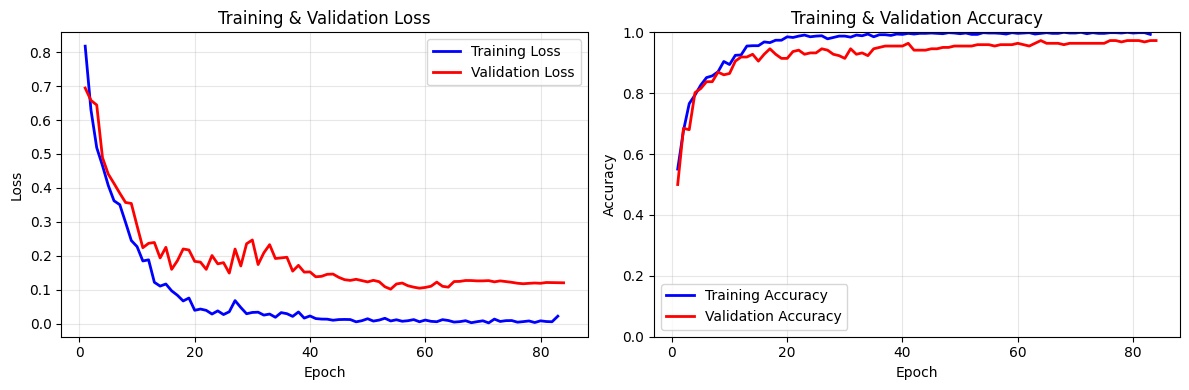

Final Training Loss: 0.0225
Final Validation Loss: 0.1207
Final Training Accuracy: 0.9932
Final Validation Accuracy: 0.9730


In [6]:
# ==============================================================================
# TRAINING VISUALIZATION
# ==============================================================================

train_losses = metrics_logger.train_metrics['loss']
val_losses = metrics_logger.val_metrics['loss']
train_accuracies = metrics_logger.train_metrics['accuracy']
val_accuracies = metrics_logger.val_metrics['accuracy']

# Plot training curves
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
if train_losses and val_losses:
    # Create separate epoch ranges for train and validation (they might have different lengths)
    train_epochs = range(1, len(train_losses) + 1)
    val_epochs = range(1, len(val_losses) + 1)
    
    plt.plot(train_epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    plt.plot(val_epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 2, 2)
if train_accuracies and val_accuracies:
    # Create separate epoch ranges for train and validation accuracies
    train_acc_epochs = range(1, len(train_accuracies) + 1)
    val_acc_epochs = range(1, len(val_accuracies) + 1)
    
    plt.plot(train_acc_epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(val_acc_epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Display final metrics
if train_losses:
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
if val_losses:
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
if train_accuracies:
    print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
if val_accuracies:
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")


Confusion Matrix:
[[135   4]
 [  5 134]]

Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.97      0.97       139
           2       0.97      0.96      0.97       139

    accuracy                           0.97       278
   macro avg       0.97      0.97      0.97       278
weighted avg       0.97      0.97      0.97       278



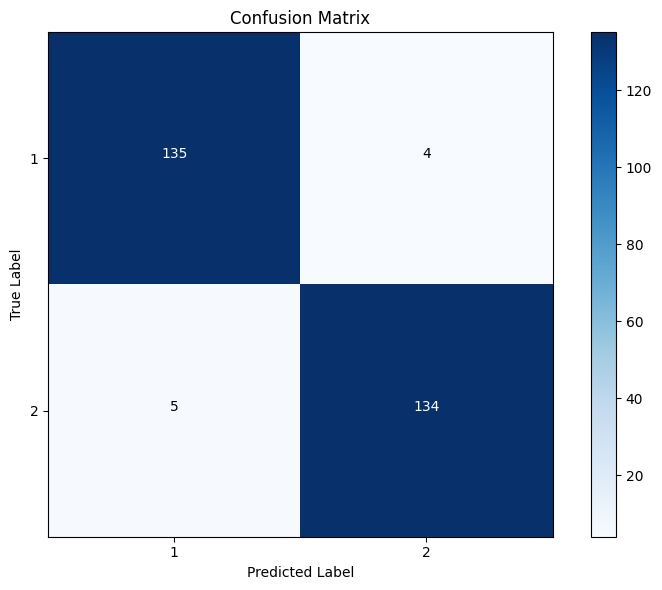

In [7]:
# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

# Get original labels back
test_labels_original = label_encoder.inverse_transform(Y_test.numpy())
pred_labels_original = label_encoder.inverse_transform(test_predictions)

# Confusion matrix
cm = confusion_matrix(test_labels_original, pred_labels_original)
print("Confusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels_original, pred_labels_original))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(test_labels_original)))
plt.xticks(tick_marks, np.unique(test_labels_original))
plt.yticks(tick_marks, np.unique(test_labels_original))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add numbers to confusion matrix
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [8]:
# Save the trained model
import torch

# Save the complete model
torch.save(model.state_dict(), 'custom_convlun_model.pth')

print("Model saved successfully!")
print("Files created:")
print("- custom_convlun_model.pth: Model weights and parameters")


Model saved successfully!
Files created:
- custom_convlun_model.pth: Model weights and parameters
